<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 3: Scaling up (Food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning. Now it's time to scale up to all of the classese in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training dataset, leveraging the power of deep learning.

Visit the original Food101 paper [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

Our baseline is to beat 50.76 accuracy they used (Random forest classifier)

In [ ]:
!nvidia-smi

Wed Jul 27 06:49:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper funcitons to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-27 06:49:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-27 06:49:15 (66.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper funcions to our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, sol et's download it

The data we're downloading comes from the original Food101 dataset but it has been preprocessed using the [`image_data_modification`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-07-27 06:49:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 74.125.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  86.6MB/s    in 16s     

2022-07-27 06:49:37 (94.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 epochs on train dataset and validate on 15% of the test data, to save epoch time.

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers ()
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# SEtup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
initial_epochs = 5

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epochs,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 54s 157ms/step - loss: 3.4703 - accuracy: 0.2401 - val_loss: 2.6540 - val_accuracy: 0.3829
Epoch 2/5
237/237 [==============================] - 35s 145ms/step - loss: 2.3526 - accuracy: 0.4609 - val_loss: 2.2339 - val_accuracy: 0.4492
Epoch 3/5
237/237 [==============================] - 30s 124ms/step - loss: 1.9790 - accuracy: 0.5287 - val_loss: 2.0757 - val_accuracy: 0.4711
Epoch 4/5
237/237 [==============================] - 29s 122ms/step - loss: 1.7610 - accuracy: 0.5793 - val_loss: 1.9563 - val_accuracy: 0.4907
Epoch 5/5
237/237 [==============================] - 28s 116ms/step - loss: 1.6042 - accuracy: 0.6063 - val_loss: 1.9511 - val_accuracy: 0.4883


In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 55s 69ms/step - loss: 1.7334 - accuracy: 0.5449


[1.733370304107666, 0.5448712706565857]

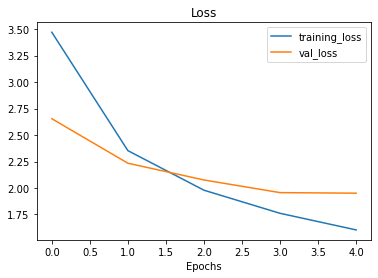

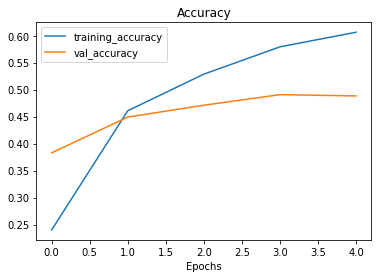

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

There is overfitting, but it is already a good beginning. We've already beaten the paper results

## Fine-tuning

In [ ]:
base_model.trainable=True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with learning rate ten times lower 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layer in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


>**Note -** Input layer and data augmentation actually do not have trainable parameters. Input layer is just an architecture to connect the input layers to our model, while data augmentation follows the Sequential model. Tensorflow assigns these by default, but they are not trainable.

In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Load weights 
model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [ ]:
history_all_classes_10_percent_5l_finetuned = model.fit(train_data_all_10_percent,
                                                        epochs=10,
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15*len(test_data)),
                                                        initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 35s 119ms/step - loss: 2.2384 - accuracy: 0.4393 - val_loss: 2.0072 - val_accuracy: 0.4852
Epoch 6/10
237/237 [==============================] - 27s 112ms/step - loss: 1.3808 - accuracy: 0.6210 - val_loss: 2.2189 - val_accuracy: 0.4658
Epoch 7/10
237/237 [==============================] - 27s 111ms/step - loss: 1.0213 - accuracy: 0.7166 - val_loss: 2.0178 - val_accuracy: 0.4968
Epoch 8/10
237/237 [==============================] - 28s 118ms/step - loss: 0.7837 - accuracy: 0.7747 - val_loss: 1.9575 - val_accuracy: 0.5246
Epoch 9/10
237/237 [==============================] - 26s 108ms/step - loss: 0.6196 - accuracy: 0.8183 - val_loss: 2.0347 - val_accuracy: 0.5416
Epoch 10/10
237/237 [==============================] - 26s 108ms/step - loss: 0.5087 - accuracy: 0.8446 - val_loss: 2.0199 - val_accuracy: 0.5352


In [ ]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 2.0012 - accuracy: 0.5459


In [ ]:
all_classes_10_percent_fine_tune_results

[2.001220226287842, 0.5459010004997253]

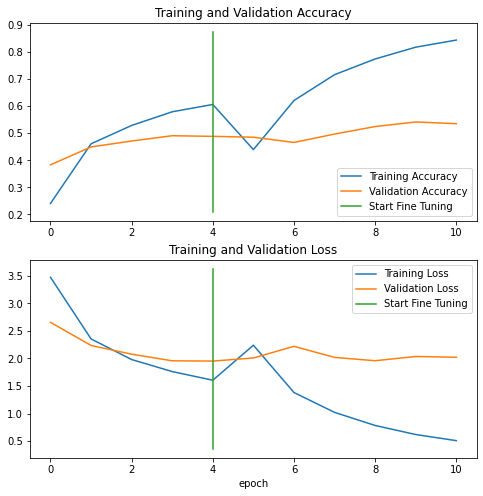

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_5l_finetuned)

## Saving and loading our model

To use our model in an external application, we need to store it somewhere
model.save()

In [ ]:
model.save("drive/MyDrive/tensorflow-stuff/101_food_classes_10_percent_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/101_food_classes_10_percent_big_dog_model/assets


In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow-stuff/101_food_classes_10_percent_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 55s 68ms/step - loss: 2.0012 - accuracy: 0.5459


[2.001220226287842, 0.5459010004997253]

In [ ]:
# Results from loaded model above should be very similar to the results below
all_classes_10_percent_fine_tune_results

[2.001220226287842, 0.5459010004997253]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize later and find out which predicitons were most wrong

In [ ]:
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip 

--2022-07-27 07:00:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.212.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   141MB/s    in 0.3s    

2022-07-27 07:00:16 (141 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 56s 68ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
preds_probs = model.predict(test_data,verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 57s 71ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
# Let's see the shape of our predictions
preds_probs.shape

(25250, 101)

>**Note -** Remember we have 101 predictions. What does softmax do? Remember that it distributes the categories and the sum of their probabilities is always 1. *The more classes, the smaller the probabilities may get*.

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542134e-02, 3.5742110e-06, 4.1376989e-02, ..., 1.4138677e-09,
        8.3530736e-05, 3.0897488e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780541e-04, ..., 5.4286997e-05,
        7.8362507e-12, 9.8466213e-10],
       [9.5925868e-01, 3.2533582e-05, 1.4866934e-03, ..., 7.1891060e-07,
        5.4397316e-07, 4.0275772e-05],
       ...,
       [4.7313222e-01, 1.2931199e-07, 1.4805659e-03, ..., 5.9749966e-04,
        6.6969100e-05, 2.3469256e-05],
       [4.4571884e-02, 4.7265442e-07, 1.2258486e-01, ..., 6.3498392e-06,
        7.5318376e-06, 3.6778590e-03],
       [7.2438973e-01, 1.9249813e-09, 5.2311054e-05, ..., 1.2291399e-03,
        1.5792777e-09, 9.6395757e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like
preds_probs[0]

array([5.9542134e-02, 3.5742110e-06, 4.1376989e-02, 1.0660594e-09,
       8.1614573e-09, 8.6639469e-09, 8.0927026e-07, 8.5652727e-07,
       1.9859068e-05, 8.0977821e-07, 3.1727796e-09, 9.8673718e-07,
       2.8532225e-04, 7.8048884e-10, 7.4230251e-04, 3.8916369e-05,
       6.4740229e-06, 2.4977251e-06, 3.7891088e-05, 2.0678401e-07,
       1.5538462e-05, 8.1507005e-07, 2.6230512e-06, 2.0010719e-07,
       8.3827507e-07, 5.4215920e-06, 3.7391094e-06, 1.3150555e-08,
       2.7761490e-03, 2.8051913e-05, 6.8562661e-10, 2.5574802e-05,
       1.6688893e-04, 7.6406981e-10, 4.0452849e-04, 1.3150681e-08,
       1.7957424e-06, 1.4448199e-06, 2.3062952e-02, 8.2466835e-07,
       8.5365667e-07, 1.7138624e-06, 7.0525148e-06, 1.8402163e-08,
       2.8553370e-07, 7.9483289e-06, 2.0681648e-06, 1.8525219e-07,
       3.3619635e-08, 3.1522560e-04, 1.0410960e-05, 8.5448096e-07,
       8.4741843e-01, 1.0555463e-05, 4.4094864e-07, 3.7404097e-05,
       3.5306119e-05, 3.2489061e-05, 6.7314468e-05, 1.2852564e

> **Note -** Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.


In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the best predicted probability by th emodel for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542134e-02 3.5742110e-06 4.1376989e-02 1.0660594e-09 8.1614573e-09
 8.6639469e-09 8.0927026e-07 8.5652727e-07 1.9859068e-05 8.0977821e-07
 3.1727796e-09 9.8673718e-07 2.8532225e-04 7.8048884e-10 7.4230251e-04
 3.8916369e-05 6.4740229e-06 2.4977251e-06 3.7891088e-05 2.0678401e-07
 1.5538462e-05 8.1507005e-07 2.6230512e-06 2.0010719e-07 8.3827507e-07
 5.4215920e-06 3.7391094e-06 1.3150555e-08 2.7761490e-03 2.8051913e-05
 6.8562661e-10 2.5574802e-05 1.6688893e-04 7.6406981e-10 4.0452849e-04
 1.3150681e-08 1.7957424e-06 1.4448199e-06 2.3062952e-02 8.2466835e-07
 8.5365667e-07 1.7138624e-06 7.0525148e-06 1.8402163e-08 2.8553370e-07
 7.9483289e-06 2.0681648e-06 1.8525219e-07 3.3619635e-08 3.1522560e-04
 1.0410960e-05 8.5448096e-07 8.4741843e-01 1.0555463e-05 4.4094864e-07
 3.7404097e-05 3.5306119e-05 3.2489061e-05 6.7314468e-05 1.2852564e-08
 2.6219754e-10 1.0318126e-05 8.5744177e-05 1.

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now we've got a predictions array of all of our model's predictions. To evaluate them, we need to compare them to the original test dataset

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array, is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

In [ ]:
sklearn_accuracy

0.6077623762376237

In [ ]:
# does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [ ]:
# Get a list of classes
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# We need to make some changes to make_confusion_matrix function to ensure the x-labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

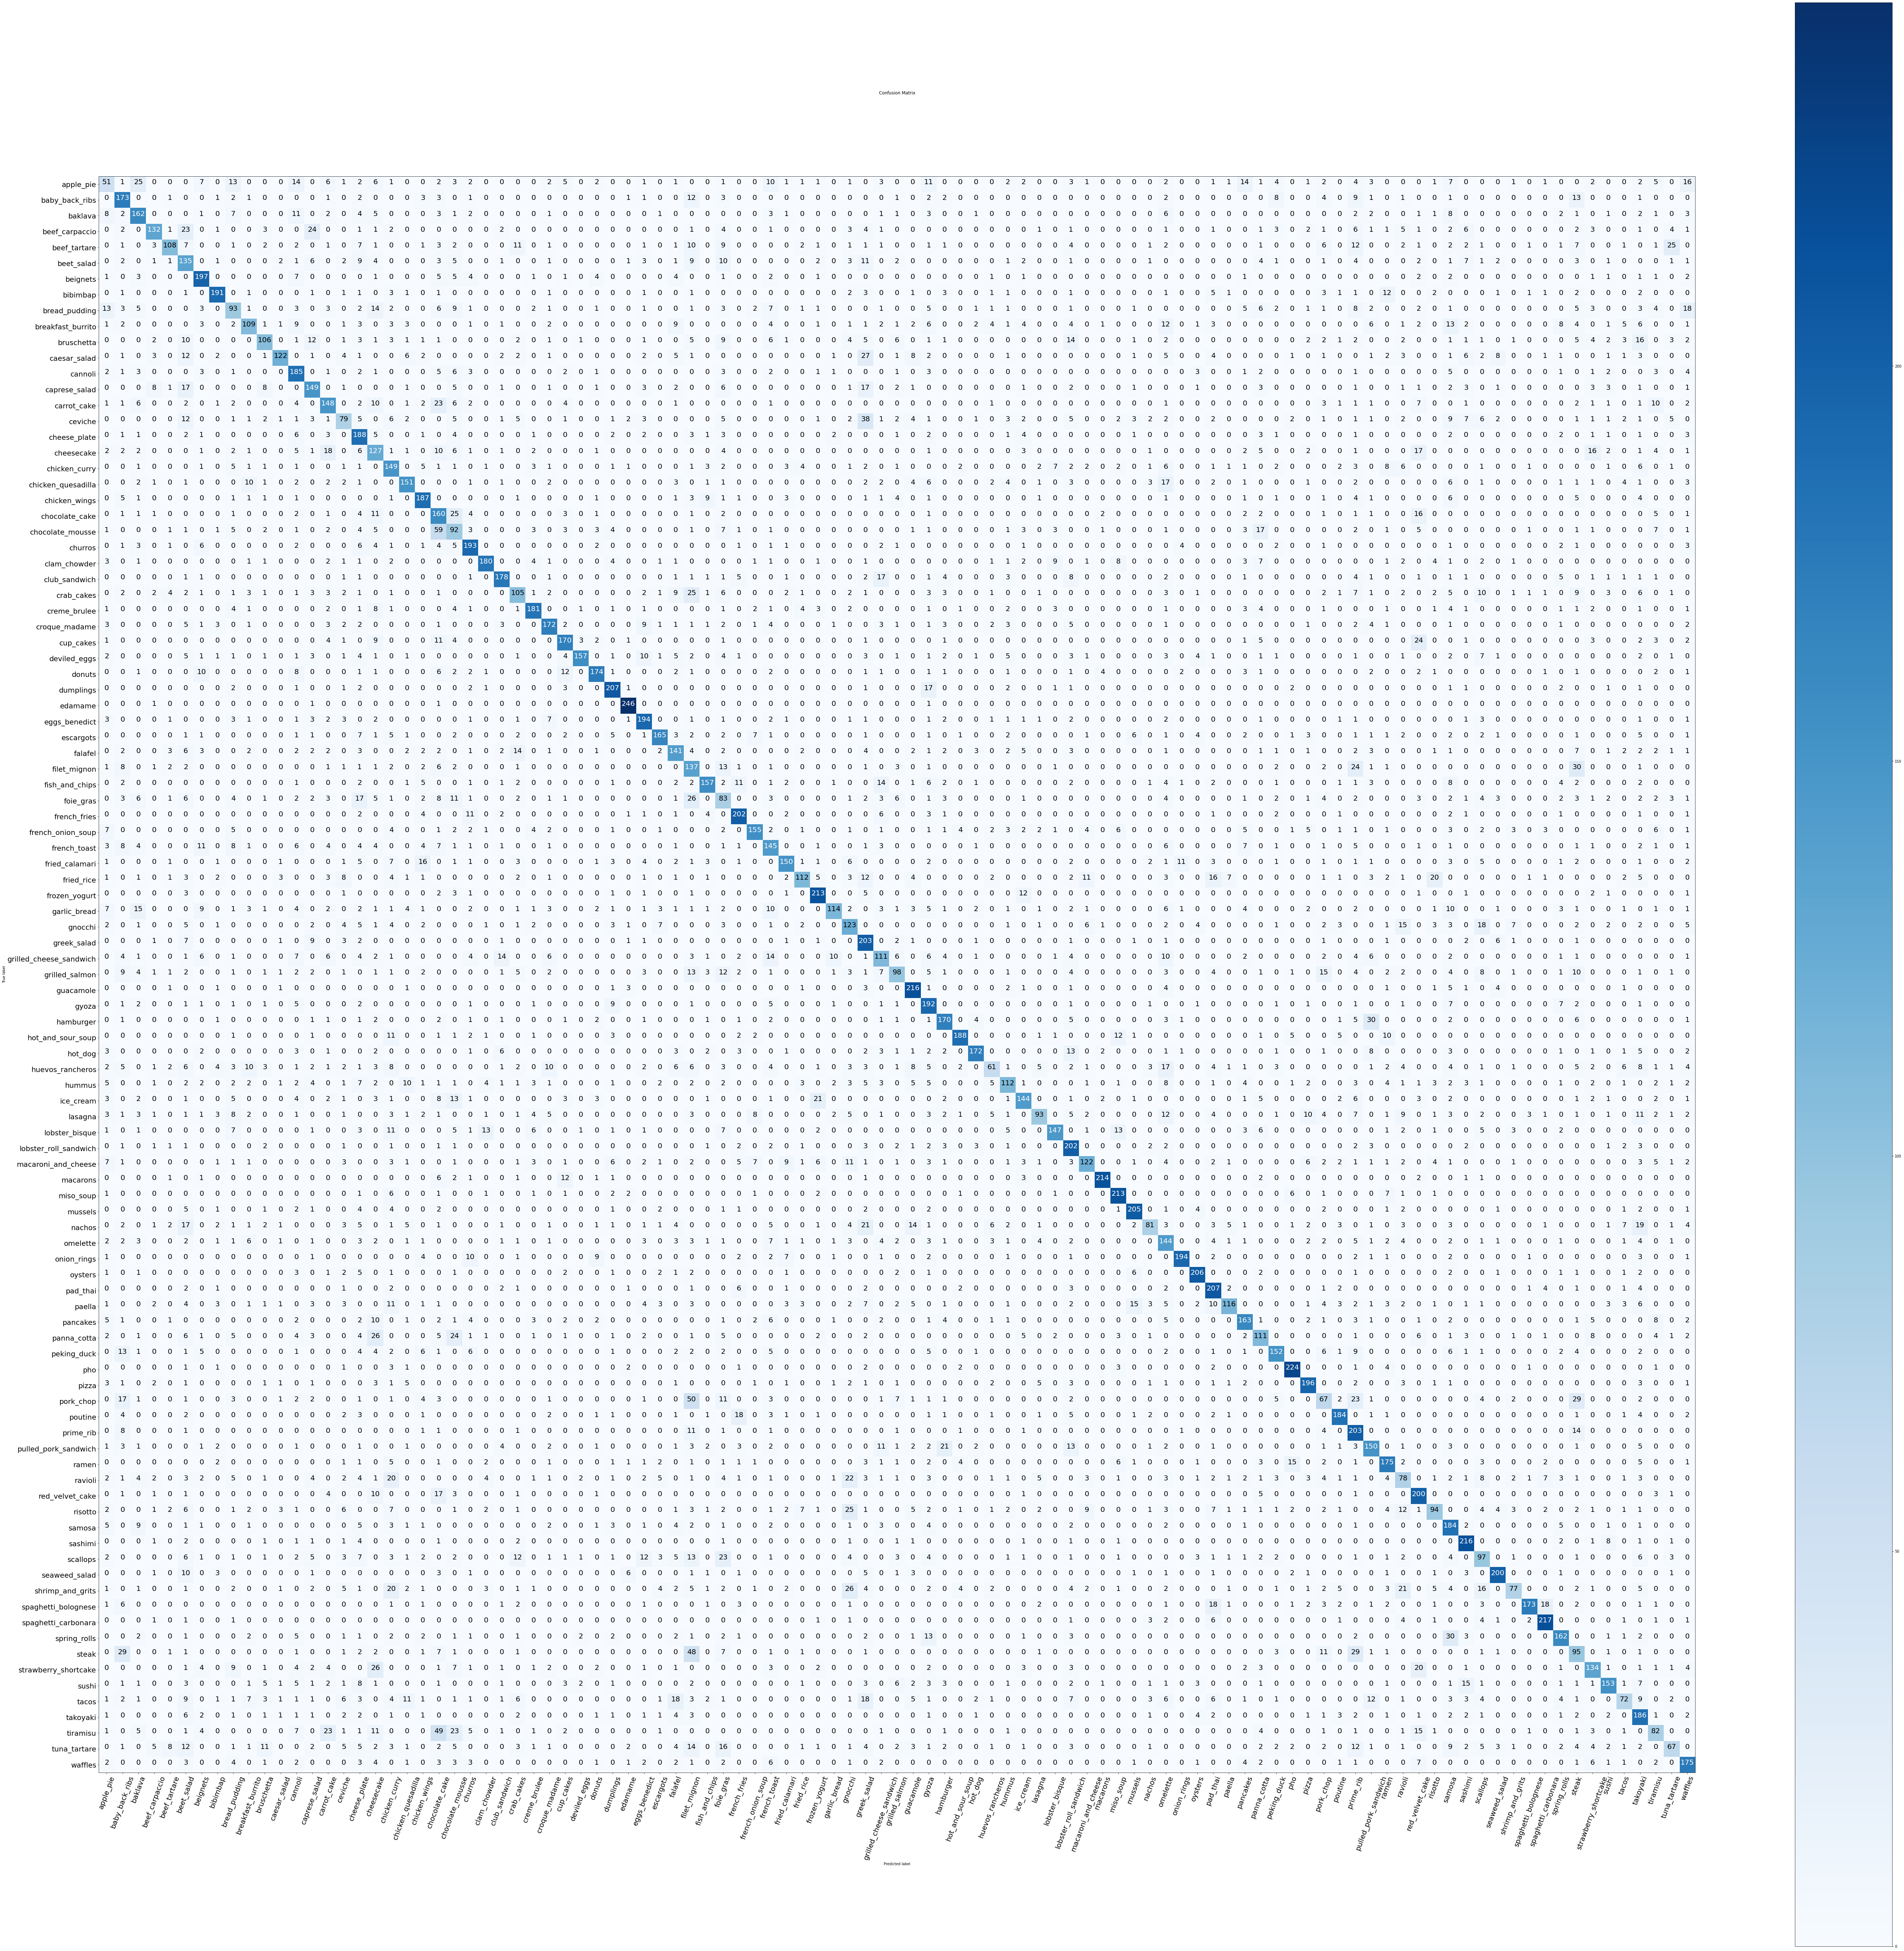

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix



make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

Let's plot all of our classes F1-scores..


In [ ]:
# Create empty dictionary
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores.tail(10)

class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

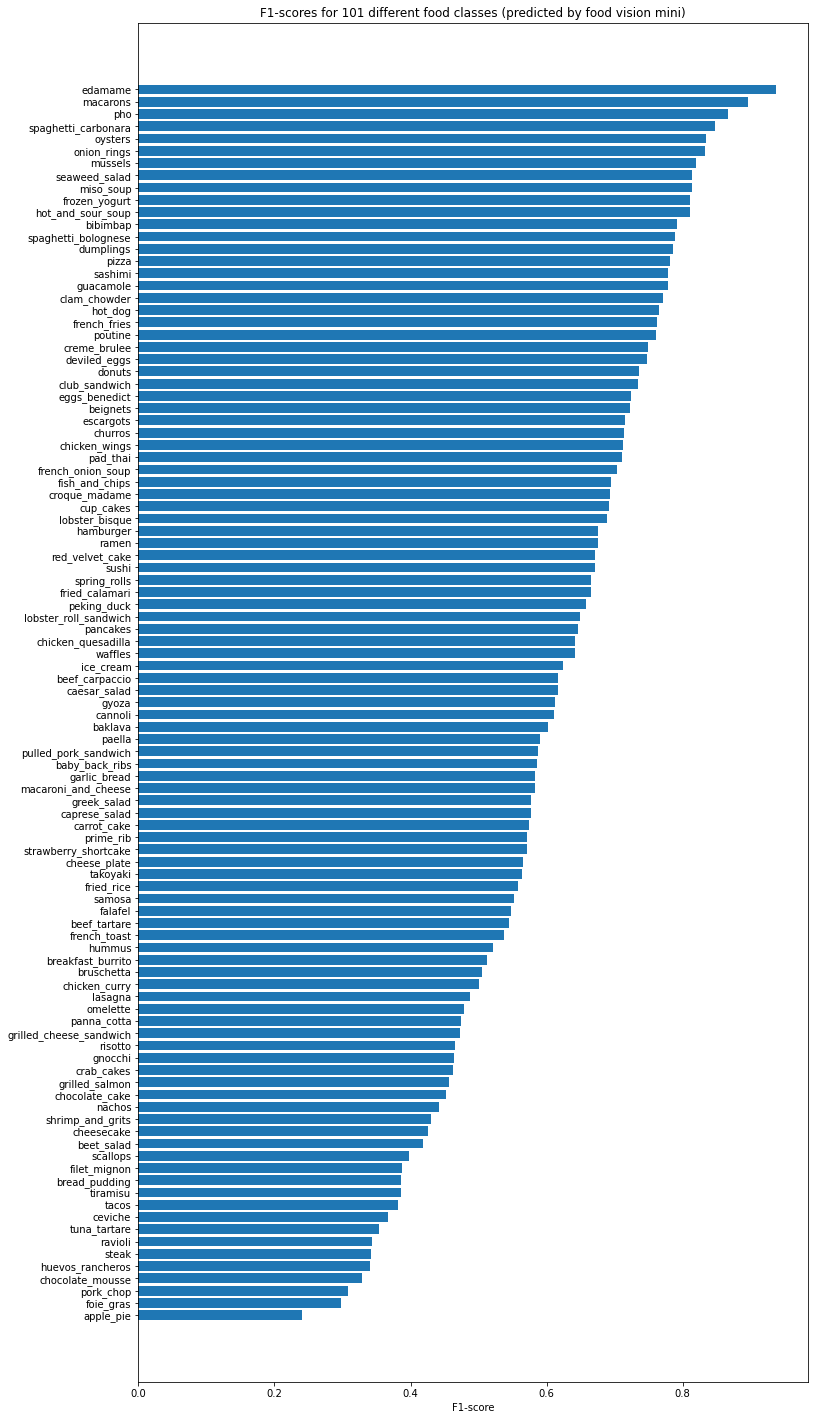

In [ ]:
fig, ax = plt.subplots(figsize=(12,25));
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values);
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes (predicted by food vision mini)");
ax.invert_yaxis(); # reverse order of our plot

## Visualizing predictions on custom images

Now, this is the real test. How does our model go on food images not even in our test dataset(images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images. Specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the picture values between 0 & 1 (if necessary)


In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    # Rescale the image(get all values between 0 and 1)
    return img/255.
  else:
    return img


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and the true label


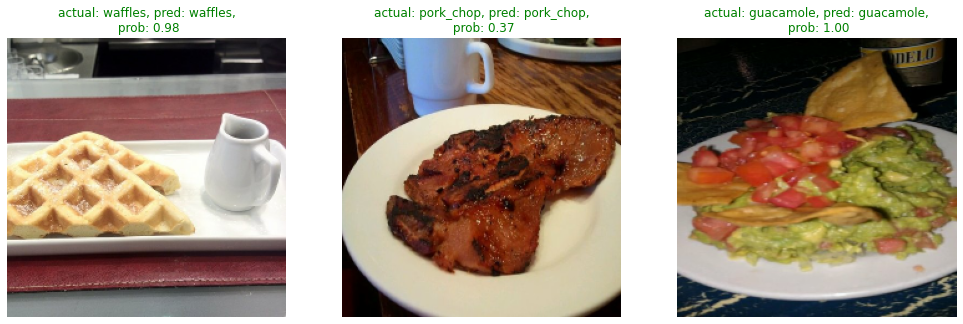

In [ ]:
import os
import random

plt.figure(figsize=(17,10));
for i in range(3):
  # Choose a random image from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, 0)) # get prediction probability
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  # print(pred_prob, pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # If predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class},\n prob: {pred_prob.max():.2f}", color=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file path in the test dataset using `list_files()` method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (form our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (Have the highest prediction probability predictions at the top).
5. visualize the image with the highest prediction probabilities but have the wrong prediction.


In [ ]:
# Get all of the image file 
filepaths = []

for filepath in test_data.list_files(test_dir+"*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]



[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
  # Create a DAtaFrame of different parameters for each of ur test images
  pred_df = pd.DataFrame({"img_path": filepaths,
                          "y_true": y_labels,
                          "y_pred": pred_classes,
                          "pred_conf": preds_probs.max(axis=1),
                          "y_true_classname": [class_names[i] for i in y_labels],
                          "y_pred_classname": [class_names[i] for i in pred_classes]})
  

In [ ]:
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367900        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878027          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501951          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367900        apple_pie             prime_rib         False

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

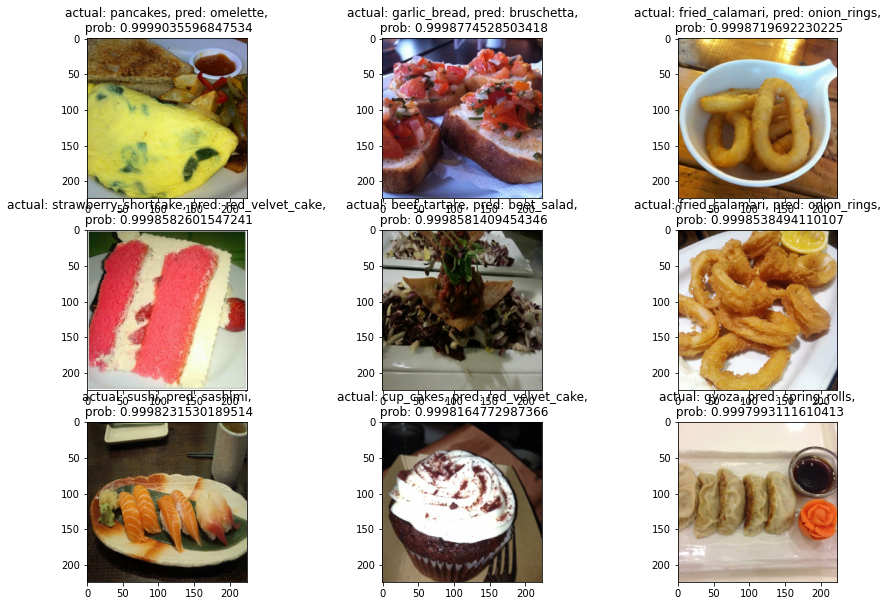

In [ ]:
# Visualize the test data samples which have the wrong prediction but highest prediction probability
images_to_view = 9
start_index = 10

plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname},\n prob: {pred_prob}")

## TEst out the big dodg model on our own custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-07-27 07:48:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 74.125.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.3’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-07-27 07:48:54 (127 MB/s) - ‘custom_food_images.zip.3’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg']

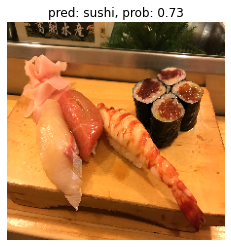

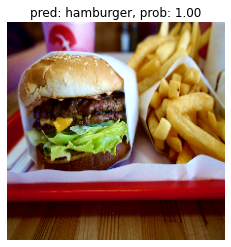

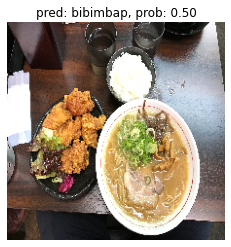

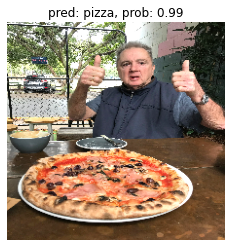

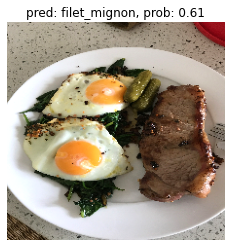

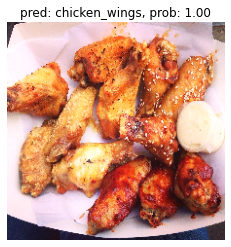

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # no need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # Get the index with the highest prediction probability

  # Plot the appropriate information
  plt.figure();
  plt.imshow(img/225.);
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Now, I manually uploaded some images I found, therefore note this following script will not work unless images are uploaded into a created folder with the same name:


In [ ]:
other_custom_food_images = ["othercustom_food_images/" + img_path for img_path in os.listdir("othercustom_food_images")]
other_custom_food_images

['othercustom_food_images/tf-sample-grilled-salmon1.jpg',
 'othercustom_food_images/tf-sample-lasagna.jpg',
 'othercustom_food_images/.ipynb_checkpoints',
 'othercustom_food_images/tf-sample-spaghetticarbonara.jpg',
 'othercustom_food_images/tf-sample-gnocchi.jpg']

In [ ]:
img = load_and_prep_image("/content/othercustom_food_images/tf-sample-gnocchi.jpg",scale=False)
pred_prob = model.predict(tf.expand_dims(img, axis=0))

In [ ]:
pred_class = class_names[pred_prob.argmax()]
pred_class

'cheese_plate'

In [ ]:
img = load_and_prep_image("/content/othercustom_food_images/tf-sample-grilled-salmon1.jpg",scale=False)
pred_prob = model.predict(tf.expand_dims(img,axis=0))
pred_class = class_names[pred_prob.argmax()]
pred_class

'baby_back_ribs'

In [ ]:
img = load_and_prep_image("/content/othercustom_food_images/tf-sample-lasagna.jpg",scale=False)
pred_prob = model.predict(tf.expand_dims(img,axis=0))
pred_class = class_names[pred_prob.argmax()]
pred_class

'baby_back_ribs'